In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set up plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

# Load the feature engineered data (Assuming the file is 'n_indresp_FINAL_FEATURES_OPTIMIZED02.csv'
# and the boolean conversion was applied or saved in the last step)
file_path = '/Users/wanderer/DSS_Thesis/data/processed/n_indresp_FINAL_FEATURES_OPTIMIZED02.csv'
df = pd.read_csv(file_path)

# --- Ensure Dtypes are correct (Re-run Bool to Int64 for robustness) ---
bool_cols = df.select_dtypes(include='bool').columns
for col in bool_cols:
    # Convert True/False to 1/0 and then to Nullable Integer
    df[col] = df[col].astype(int).astype('Int64')


--- 1. Missing Value Count for Key Features ---
ghq12_continuous_score                1357
prev_ghq12_score                     11822
ghq12_score_change                   12268
last_unemployment_duration_months    33166
loneliness_score                      1064
log_total_income                        18
dtype: int64


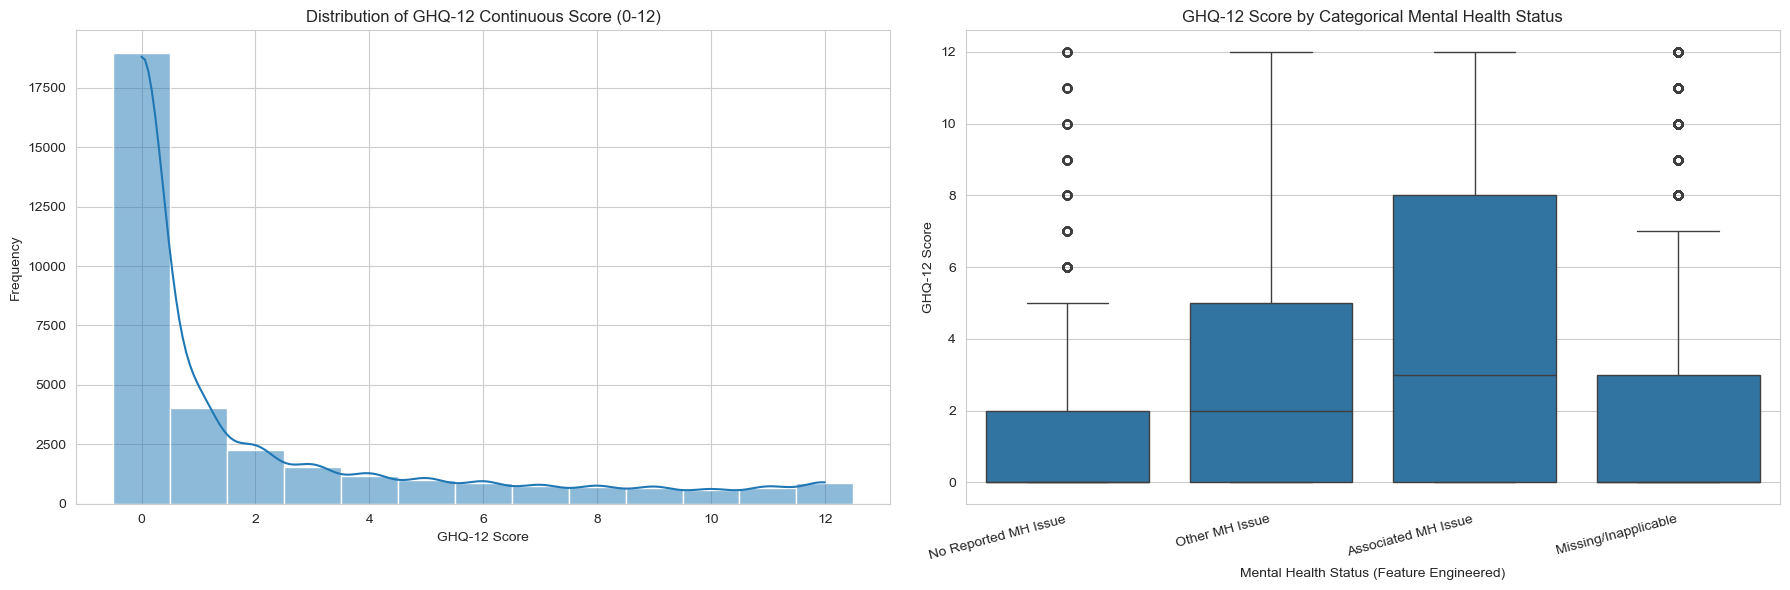


Saved: eda_step1_outcome_analysis.png (GHQ-12 Distribution and Conditional Boxplot)


In [7]:


# ==============================================================================
# Phase I & II: Missingness & Outcome Distribution
# ==============================================================================

# 1. 缺失值诊断 (Missingness of Key Variables)
print("\n--- 1. Missing Value Count for Key Features ---")
key_missingness = df[['ghq12_continuous_score', 
                      'prev_ghq12_score', 
                      'ghq12_score_change', 
                      'last_unemployment_duration_months',
                      'loneliness_score',
                      'log_total_income']].isnull().sum()
print(key_missingness)

# 2. 目标变量分布 (Outcome Distribution)
plt.figure(figsize=(18, 6))

# 2a. GHQ-12 Continuous Score Distribution (Hist + KDE)
plt.subplot(1, 2, 1)
sns.histplot(df['ghq12_continuous_score'], bins=13, kde=True, discrete=True)
plt.title('Distribution of GHQ-12 Continuous Score (0-12)')
plt.xlabel('GHQ-12 Score')
plt.ylabel('Frequency')

# 2b. GHQ-12 Conditional Distribution by Mental Health Status
plt.subplot(1, 2, 2)
# Ensure the order of categories for better visualization
status_order = ['No Reported MH Issue', 'Other MH Issue', 'Associated MH Issue', 'Missing/Inapplicable']
df['mental_health_status'] = pd.Categorical(df['mental_health_status'], categories=status_order, ordered=True)
sns.boxplot(x='mental_health_status', y='ghq12_continuous_score', data=df)
plt.title('GHQ-12 Score by Categorical Mental Health Status')
plt.xlabel('Mental Health Status (Feature Engineered)')
plt.ylabel('GHQ-12 Score')
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()
plt.savefig('eda_step1_outcome_analysis.png')
plt.close()

print("\nSaved: eda_step1_outcome_analysis.png (GHQ-12 Distribution and Conditional Boxplot)")

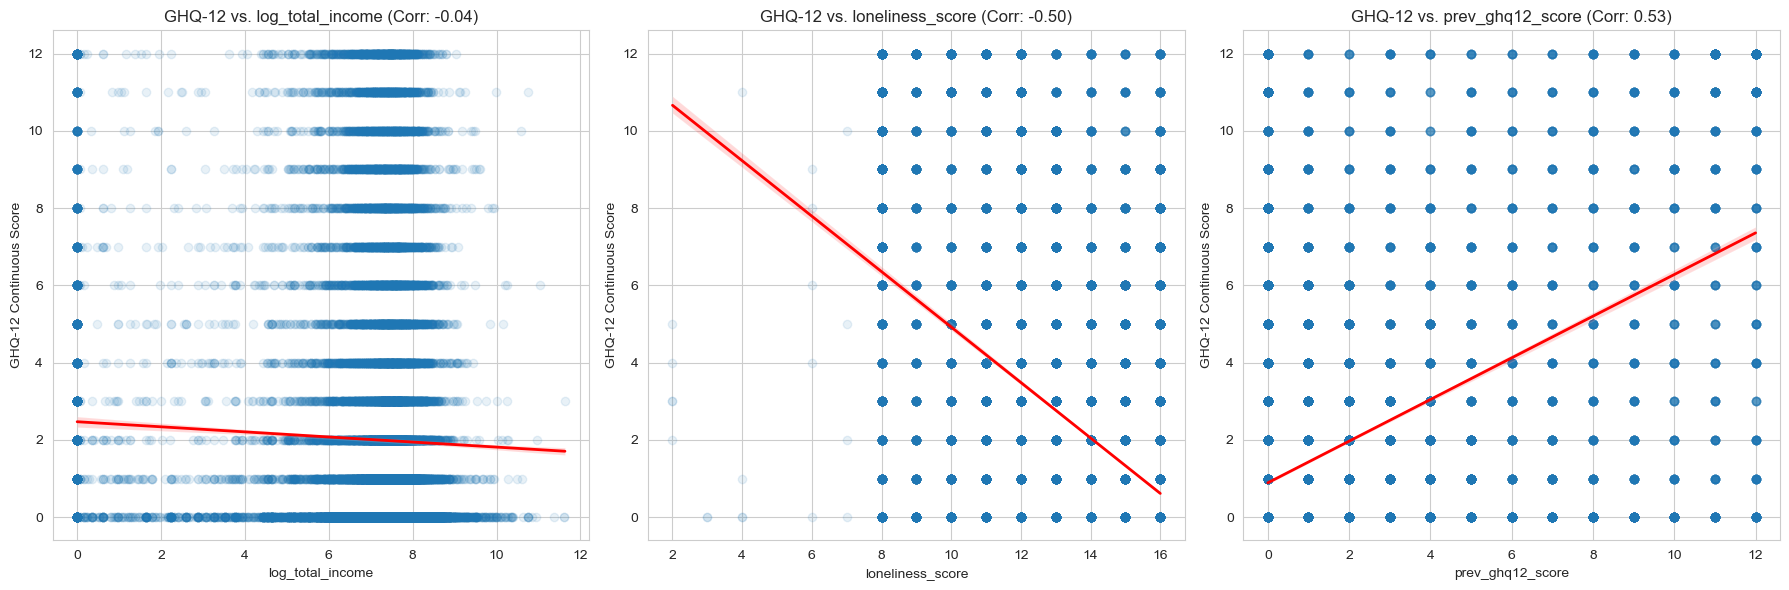


Saved: eda_step2_continuous_relations.png (GHQ-12 vs. Log Income, Loneliness, Prev GHQ)


In [15]:
# ==============================================================================
# Phase II: Relationship Deepening - Continuous Variables vs. GHQ-12
# ==============================================================================

# Variables of Interest
rel_vars = ['log_total_income', 'loneliness_score', 'prev_ghq12_score']

plt.figure(figsize=(18, 6))

for i, var in enumerate(rel_vars):
    plt.subplot(1, 3, i + 1)
    
    # Use regplot to show scatter and linear regression line
    sns.regplot(x=var, y='ghq12_continuous_score', data=df, 
                scatter_kws={'alpha':0.1}, line_kws={'color':'red', 'linewidth': 2})
    
    # Calculate Pearson correlation coefficient
    corr = df[['ghq12_continuous_score', var]].corr().iloc[0, 1]
    
    plt.title(f'GHQ-12 vs. {var} (Corr: {corr:.2f})')
    plt.xlabel(var)
    plt.ylabel('GHQ-12 Continuous Score')

plt.tight_layout()
plt.savefig('eda_step2_continuous_relations.png')
plt.show()
plt.close()

print("\nSaved: eda_step2_continuous_relations.png (GHQ-12 vs. Log Income, Loneliness, Prev GHQ)")

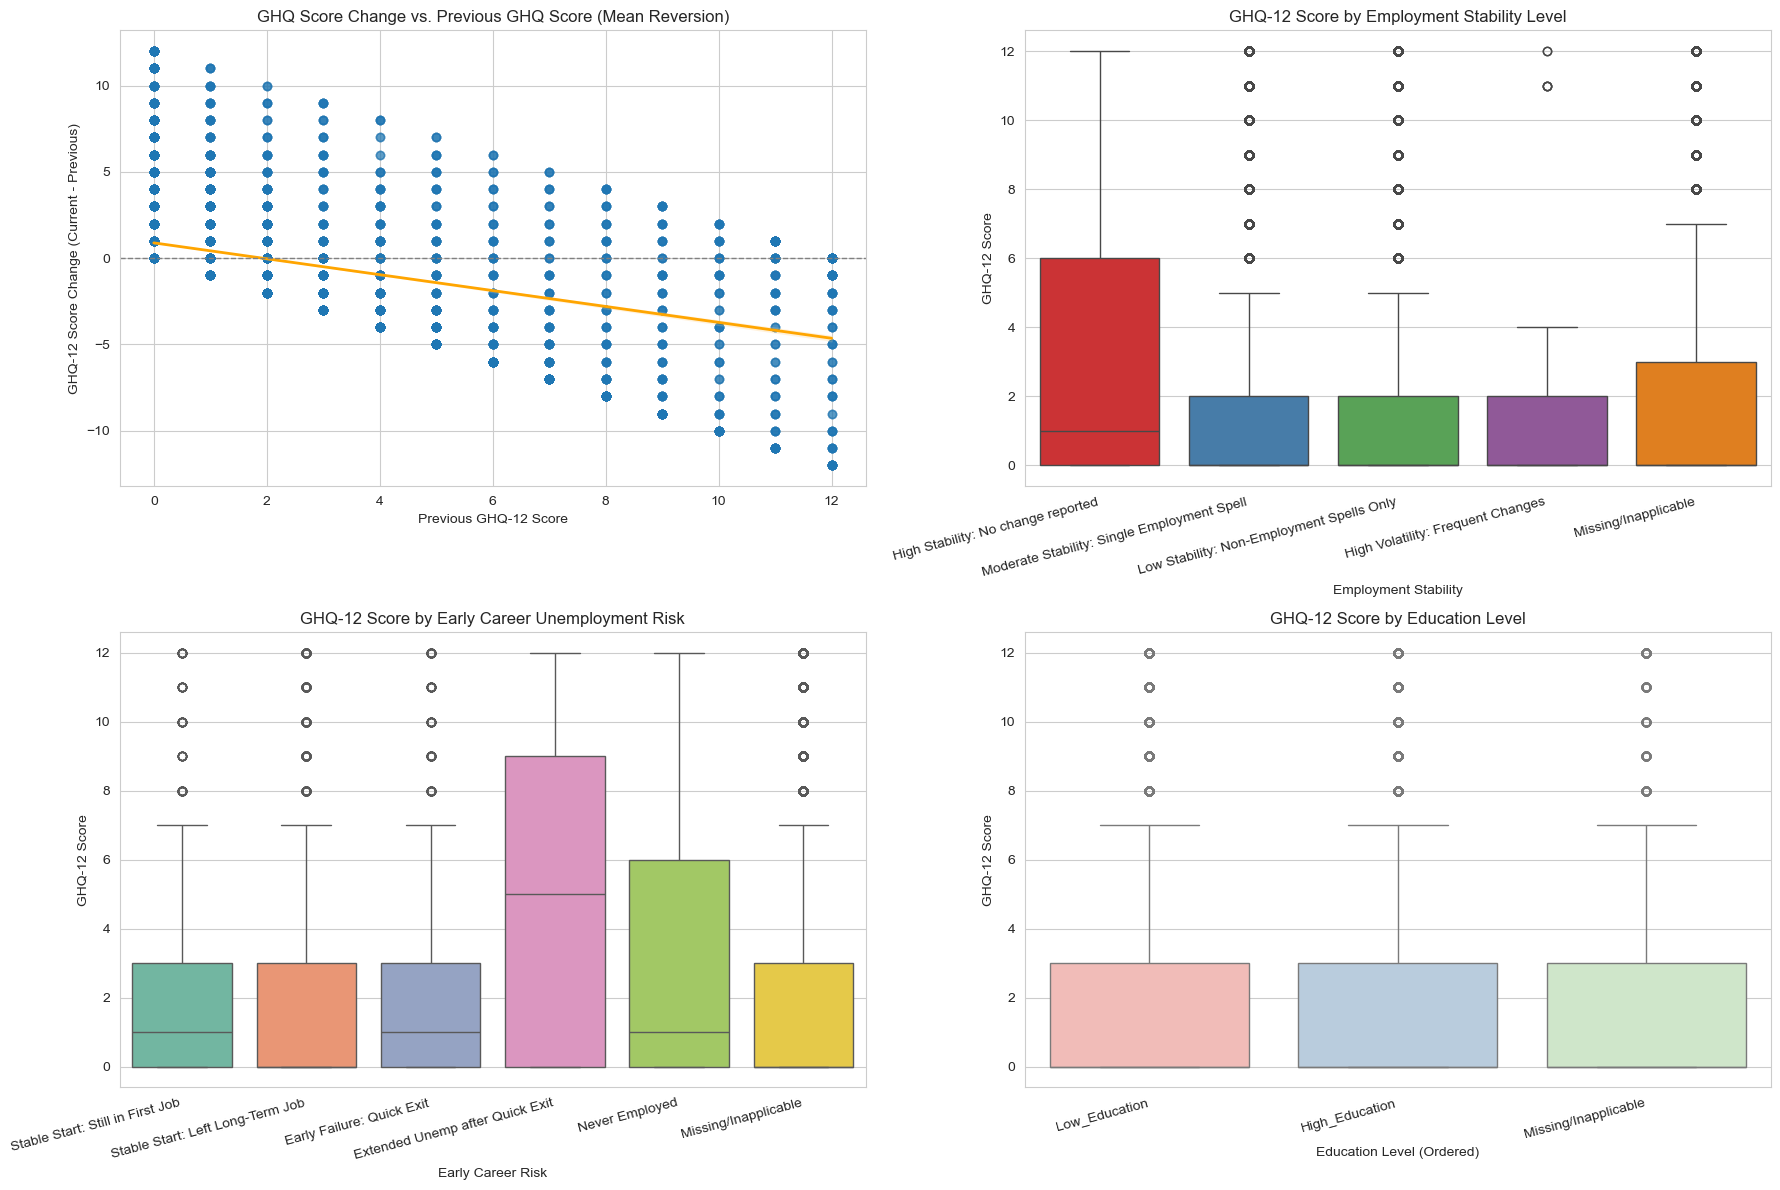


Saved: eda_step3_core_relations_fixed.png (Dynamic Change, Employment, and Education)


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set up plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (18, 12)
# --- Ensure Dtypes are correct (Re-run Bool to Int64 for robustness) ---
bool_cols = df.select_dtypes(include='bool').columns
for col in bool_cols:
    df[col] = df[col].astype(int).astype('Int64')

# ==============================================================================
# Phase II: Dynamic Change, Employment, and Education Relations (Fixed Palette)
# ==============================================================================

# 3. 动态变化分析 (Mean Reversion Check)
plt.subplot(2, 2, 1)
sns.regplot(x='prev_ghq12_score', y='ghq12_score_change', data=df,
            scatter_kws={'alpha':0.1}, line_kws={'color':'orange', 'linewidth': 2})
plt.axhline(0, color='grey', linestyle='--', linewidth=1) # Reference line for no change
plt.title('GHQ Score Change vs. Previous GHQ Score (Mean Reversion)')
plt.xlabel('Previous GHQ-12 Score')
plt.ylabel('GHQ-12 Score Change (Current - Previous)')


# 4. 核心就业特征 vs. GHQ-12
# 4a. Employment Stability Level
plt.subplot(2, 2, 2)
stability_order = ['High Stability: No change reported', 'Moderate Stability: Single Employment Spell', 
                   'Low Stability: Non-Employment Spells Only', 'High Volatility: Frequent Changes', 
                   'Missing/Inapplicable']
df['employment_stability_level'] = pd.Categorical(df['employment_stability_level'], categories=stability_order, ordered=True)
# FIX: Use 'Set1' palette and assign x to hue to avoid warning/error
sns.boxplot(x='employment_stability_level', y='ghq12_continuous_score', data=df, 
            hue='employment_stability_level', palette="Set1", legend=False)
plt.title('GHQ-12 Score by Employment Stability Level')
plt.xlabel('Employment Stability')
plt.ylabel('GHQ-12 Score')
plt.xticks(rotation=15, ha='right')


# 4b. Early Career Unemployment Risk vs. GHQ-12
plt.subplot(2, 2, 3)
risk_order = ['Stable Start: Still in First Job', 'Stable Start: Left Long-Term Job', 
              'Early Failure: Quick Exit', 'Extended Unemp after Quick Exit', 
              'Never Employed', 'Missing/Inapplicable']
df['early_career_unemp_risk'] = pd.Categorical(df['early_career_unemp_risk'], categories=risk_order, ordered=True)
# FIX: Use 'Set2' palette and assign x to hue
sns.boxplot(x='early_career_unemp_risk', y='ghq12_continuous_score', data=df, 
            hue='early_career_unemp_risk', palette="Set2", legend=False)
plt.title('GHQ-12 Score by Early Career Unemployment Risk')
plt.xlabel('Early Career Risk')
plt.ylabel('GHQ-12 Score')
plt.xticks(rotation=15, ha='right')


# 4c. Education Level vs. GHQ-12
plt.subplot(2, 2, 4)
edu_order = ['Low_Education', 'High_Education', 'Missing/Inapplicable']
df['education_level'] = pd.Categorical(df['education_level'], categories=edu_order, ordered=True)
# FIX: Use 'Pastel1' palette and assign x to hue
sns.boxplot(x='education_level', y='ghq12_continuous_score', data=df, 
            hue='education_level', palette="Pastel1", legend=False)
plt.title('GHQ-12 Score by Education Level')
plt.xlabel('Education Level (Ordered)')
plt.ylabel('GHQ-12 Score')
plt.xticks(rotation=15, ha='right')


plt.tight_layout()
plt.savefig('eda_step3_core_relations_fixed.png')
plt.show()
plt.close()

print("\nSaved: eda_step3_core_relations_fixed.png (Dynamic Change, Employment, and Education)")

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Assuming df is loaded and cleaned from previous steps, including Bool to Int64 conversion

# ==============================================================================
# Phase III: Collinearity and Interaction Effect Exploration (FIXED VIF)
# ==============================================================================

# 1. 交互效应探索: 失业冲击与社会地位 (High-Status Job * Currently Unemployed)
# ------------------------------------------------------------------------------

# Create Interaction Term (Multiplication of the two binary features)
# Note: Int64 (nullable int) must be converted to float for multiplication if NaNs are involved, 
# but since these are binary indicators, we can multiply and then drop rows where either is missing.
df_interaction = df[['ghq12_continuous_score', 
                     'is_currently_unemployed', 
                     'high_status_job']].dropna()

# Create a combined status variable for plotting
def get_status(row):
    if row['is_currently_unemployed'] == 1:
        # Note: If 'high_status_job' is missing, this row would have been dropped by .dropna()
        return f"Unemployed (Status: {'High' if row['high_status_job'] == 1 else 'Low'})"
    else:
        return "Employed/Inactive (Ref.)"

df_interaction['status_group'] = df_interaction.apply(get_status, axis=1)

plt.figure(figsize=(8, 6))
group_order = ["Employed/Inactive (Ref.)", "Unemployed (Status: Low)", "Unemployed (Status: High)"]

sns.boxplot(x='status_group', y='ghq12_continuous_score', data=df_interaction,
            order=group_order, hue='status_group', palette='coolwarm', legend=False)

plt.title('GHQ-12 Score by Unemployment Status & Prior Social Status')
plt.xlabel('Employment and Social Status Group')
plt.ylabel('GHQ-12 Score')
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.savefig('eda_step4a_interaction_status.png')
plt.close()
print("\nSaved: eda_step4a_interaction_status.png (Interaction Effect Visualization)")


# 2. 多重共线性诊断 (VIF Analysis)
# ------------------------------------

# List all potential model columns (including dummy variables)
dummy_prefixes = ('marstat_final_', 'race_grp_', 'finfut_', 'nssec_', 'region_')
base_cols = ['female', 'n_age_dv', 'log_total_income', 'loneliness_score', 
             'has_disability', 'is_smoker', 'ghq12_continuous_score']

# Get all OHE columns
all_cols = list(df.columns)
vif_cols = base_cols + [col for col in all_cols if col.startswith(dummy_prefixes)]

# Drop the outcome variable
vif_cols.remove('ghq12_continuous_score')

# Create VIF DataFrame - MUST handle NaNs by dropping them for VIF calculation
df_vif = df[vif_cols].dropna()

# === FIX: Convert to standard float dtype before VIF calculation ===
df_vif = df_vif.astype(float)
# ==================================================================

print("\n--- 2. VIF Analysis for Core and OHE Features (Requires no NaNs) ---")
print(f"VIF Sample Size: {len(df_vif)} / Original: {len(df)}")

if len(df_vif) > 0:
    # Prepare matrix X with a constant (intercept) for VIF
    X = sm.add_constant(df_vif, prepend=False)
    
    # Calculate VIFs
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    # Note: Use .values only if necessary, but with the .astype(float) above, it's safer.
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    # Filter and sort VIF results
    # Ignore the Constant term, VIF is always high for one category in OHE groups
    vif_data = vif_data[vif_data['Feature'] != 'const']
    
    print("\nTop 10 VIF Scores (Potential Collinearity):\n")
    print(vif_data.sort_values(by='VIF', ascending=False).head(10).to_string())
    
else:
    print("Insufficient non-missing data to run VIF analysis after dropping NaNs.")


Saved: eda_step4a_interaction_status.png (Interaction Effect Visualization)

--- 2. VIF Analysis for Core and OHE Features (Requires no NaNs) ---
VIF Sample Size: 34221 / Original: 35471


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)



Top 10 VIF Scores (Potential Collinearity):

                       Feature  VIF
24               nssec_Routine  inf
36             marstat_final_8  inf
27          nssec_Intermediate  inf
28     nssec_Lower_supervisory  inf
29            region_SouthWest  inf
30                region_Wales  inf
31             marstat_final_9  inf
32  nssec_Missing/Inapplicable  inf
33              race_grp_Asian  inf
34                race_grp_nan  inf


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


In [31]:
# ==============================================================================
# Phase V: VIF Fix - Removing Reference Categories
# ==============================================================================

# List of OHE Reference Categories to REMOVE for model stability and interpretability.
# Removing one category from each OHE group resolves VIF=inf issues.
ohe_cols_to_drop = [
    # 1. Ethnicity (Reference: White - the majority group)
    'race_grp_White', 
    
    # 2. Marital Status (Reference: Single/Never Married - the baseline status)
    'marstat_final_9', 
    
    # 3. NS-SEC Class (Reference: Routine - lowest status job category)
    'nssec_Routine',
    
    # 4. Region (Reference: South East - a high-growth/large region)
    'region_SouthEast',
    
    # 5. Future Financial Expectation (Reference: Same - the neutral expectation)
    'finfut_3',
    
    # Note: We must also check for other implicit redundancies. 
    # For simplicity, we drop one from each explicit OHE group first.
]

# We also drop the 'const' term that was implicitly causing VIF=inf with the OHE variables.
# However, for VIF calculation, we must drop it AFTER sm.add_constant() is run.

# Apply the drops to the main DataFrame if you are running this in a Feature Engineering script
# df = df.drop(columns=ohe_cols_to_drop) # Use this in Feature Engineering flow

# For VIF re-check, we use a temporary copy:
df_vif_fixed = df.drop(columns=ohe_cols_to_drop, errors='ignore')


# 2. 多重共线性诊断 (VIF Analysis) - RE-RUN WITH FIXED COLUMNS
# -----------------------------------------------------------

# List all potential model columns (including dummy variables)
dummy_prefixes = ('marstat_final_', 'race_grp_', 'finfut_', 'nssec_', 'region_')
base_cols = ['female', 'n_age_dv', 'log_total_income', 'loneliness_score', 
             'has_disability', 'is_smoker', 'ghq12_continuous_score']

# Get all OHE columns, EXCLUDING the dropped ones.
all_cols_vif_input = [col for col in df_vif_fixed.columns if col.startswith(dummy_prefixes) or col in base_cols]

# Drop the outcome variable
all_cols_vif_input.remove('ghq12_continuous_score')

# Create VIF DataFrame - MUST handle NaNs by dropping them for VIF calculation
df_vif = df_vif_fixed[all_cols_vif_input].dropna()

# Convert to standard float dtype before VIF calculation
df_vif = df_vif.astype(float)

print("\n--- 2. VIF Analysis (FIXED: Reference Categories Removed) ---")
print(f"VIF Sample Size: {len(df_vif)} / Original: {len(df)}")

if len(df_vif) > 0:
    # Prepare matrix X with a constant (intercept) for VIF
    X = sm.add_constant(df_vif, prepend=False)
    
    # Calculate VIFs
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    # Recalculate VIFs using the fixed array X.values
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    # Filter and sort VIF results
    vif_data = vif_data[vif_data['Feature'] != 'const']
    
    print("\nTop 10 VIF Scores (Collinearity Check):\n")
    print(vif_data.sort_values(by='VIF', ascending=False).head(10).to_string())
    
else:
    print("Insufficient non-missing data to run VIF analysis after dropping NaNs.")


--- 2. VIF Analysis (FIXED: Reference Categories Removed) ---
VIF Sample Size: 34221 / Original: 35471

Top 10 VIF Scores (Collinearity Check):

                       Feature         VIF
6              marstat_final_2  450.943576
33             marstat_final_1  381.246922
41             marstat_final_5  149.992300
7              marstat_final_6  100.560276
0              marstat_final_4   27.762591
12             marstat_final_3   20.025425
21           marstat_final_nan   11.014575
26  nssec_Missing/Inapplicable    4.141849
9              marstat_final_7    3.262014
22          nssec_Intermediate    2.544517


In [41]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# --- Marital Status Simplification (Rerun) ---
single_never_cols = ['marstat_final_3'] 
partnered_cols = [
    'marstat_final_1', 'marstat_final_6', 'marstat_final_7', 
    'marstat_final_8', 'marstat_final_4'
] 
prev_partnered_cols = ['marstat_final_9', 'marstat_final_2', 'marstat_final_5']

df['marstat_simple_Single_Never'] = df[[col for col in single_never_cols if col in df.columns]].sum(axis=1).astype('Int64')
df['marstat_simple_Partnered'] = df[[col for col in partnered_cols if col in df.columns]].sum(axis=1).astype('Int64')
df['marstat_simple_Prev_Partnered'] = df[[col for col in prev_partnered_cols if col in df.columns]].sum(axis=1).astype('Int64')

# -----------------------------------------------


# 1. Define the final VIF input list
new_ohe_prefixes = ('race_grp_', 'finfut_', 'nssec_', 'region_')
new_base_cols = ['female', 'n_age_dv', 'log_total_income', 'loneliness_score', 
                 'has_disability', 'is_smoker', 'ghq12_continuous_score']

# New Marital Status Columns (Partnered, Prev_Partnered, marstat_final_nan)
new_marstat_cols = ['marstat_simple_Partnered', 'marstat_simple_Prev_Partnered', 'marstat_final_nan']

# Build the final list of columns to check
vif_cols_final = new_base_cols + [col for col in df.columns if col.startswith(new_ohe_prefixes)] + new_marstat_cols
vif_cols_final.remove('ghq12_continuous_score')
vif_cols_final = [col for col in vif_cols_final if not col.startswith('marstat_final_')] # Clean up old columns
vif_cols_final = [col for col in vif_cols_final if not col.startswith('marstat_simple_Single_Never')] # Remove Single_Never
vif_cols_final = list(set(vif_cols_final))

# 2. Prepare VIF DataFrame (Drop NaNs and Convert to Float)
df_vif = df[vif_cols_final].dropna()
df_vif = df_vif.astype(float)

# 3. Drop final Reference Categories (Non-Marital and Finfut)
vif_cols_to_drop = [
    'race_grp_White',               # Ethnicity (Majority)
    'nssec_Routine',                # NS-SEC (Lowest Status)
    'region_SouthEast',             # Region (High Growth)
    'finfut_3',                     # FinFüt (Same/Neutral) - FIX: Use corrected column name
]
df_vif_final = df_vif.drop(columns=vif_cols_to_drop, errors='ignore')


print("\n--- 2. VIF Analysis (ULTIMATE FIX) ---")
print(f"VIF Sample Size: {len(df_vif_final)} / Original: {len(df)}")

if len(df_vif_final) > 0:
    # Prepare matrix X with a constant (intercept) for VIF
    X = sm.add_constant(df_vif_final, prepend=False)
    
    # Calculate VIFs
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    # Filter and sort VIF results
    vif_data = vif_data[vif_data['Feature'] != 'const']
    
    print("\nTop 10 VIF Scores (FINAL CHECK - VIF < 5 IS GOAL):\n")
    print(vif_data.sort_values(by='VIF', ascending=False).head(10).to_string())
    
else:
    print("Insufficient non-missing data to run VIF analysis after dropping NaNs.")


--- 2. VIF Analysis (ULTIMATE FIX) ---
VIF Sample Size: 34221 / Original: 35471

Top 10 VIF Scores (FINAL CHECK - VIF < 5 IS GOAL):

                          Feature        VIF
30  marstat_simple_Prev_Partnered  15.300008
15       marstat_simple_Partnered  15.155865
3      nssec_Missing/Inapplicable   4.136020
9              nssec_Intermediate   2.543736
4                        n_age_dv   1.970431
10          nssec_Small_employers   1.837129
8                   region_London   1.767216
25               region_NorthWest   1.647686
21                region_Scotland   1.591228
32         nssec_Lower_managerial   1.585896


In [43]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# --- Marital Status Simplification (Rerun) ---
single_never_cols = ['marstat_final_3'] 
partnered_cols = [
    'marstat_final_1', 'marstat_final_6', 'marstat_final_7', 
    'marstat_final_8', 'marstat_final_4'
] 
prev_partnered_cols = ['marstat_final_9', 'marstat_final_2', 'marstat_final_5']

df['marstat_simple_Single_Never'] = df[[col for col in single_never_cols if col in df.columns]].sum(axis=1).astype('Int64')
df['marstat_simple_Partnered'] = df[[col for col in partnered_cols if col in df.columns]].sum(axis=1).astype('Int64')
df['marstat_simple_Prev_Partnered'] = df[[col for col in prev_partnered_cols if col in df.columns]].sum(axis=1).astype('Int64')
# -----------------------------------------------


# 1. Define the final VIF input list
new_ohe_prefixes = ('race_grp_', 'finfut_', 'nssec_', 'region_')
new_base_cols = ['female', 'n_age_dv', 'log_total_income', 'loneliness_score', 
                 'has_disability', 'is_smoker', 'ghq12_continuous_score']

# New Marital Status Columns: ONLY keep the two predictive categories. 
# The reference is 'Single_Never' OR 'Missing' (if single_never is missing).
new_marstat_cols = ['marstat_simple_Partnered', 'marstat_simple_Prev_Partnered'] 

# 2. Build the final list of columns to check
vif_cols_final = new_base_cols + [col for col in df.columns if col.startswith(new_ohe_prefixes)] + new_marstat_cols
vif_cols_final.remove('ghq12_continuous_score') # Remove outcome

# 3. Clean up the list to only include desired features (Removing ALL old OHE columns, including finfut_nan and marstat_final_nan)
vif_cols_final = [col for col in vif_cols_final if not col.startswith('marstat_final_')]
vif_cols_final = [col for col in vif_cols_final if not col.startswith('finfut_nan')] # Removing finfut_nan OHE column

vif_cols_final = list(set(vif_cols_final))

# 4. Prepare VIF DataFrame (Drop NaNs and Convert to Float)
# By removing the explicit OHE for marstat_nan and finfut_nan, we rely on pandas dropna() 
# to ensure the remaining data is complete.
df_vif = df[vif_cols_final].dropna()
df_vif = df_vif.astype(float)

# 5. Drop final Reference Categories (Non-Marital and Finfut)
vif_cols_to_drop = [
    'race_grp_White',               # Ethnicity (Majority)
    'nssec_Routine',                # NS-SEC (Lowest Status)
    'region_SouthEast',             # Region (High Growth)
    'finfut_3',                     # FinFüt (Same/Neutral) 
]
df_vif_final = df_vif.drop(columns=vif_cols_to_drop, errors='ignore')


print("\n--- 2. VIF Analysis (ULTIMATE FINAL FIX) ---")
print(f"VIF Sample Size: {len(df_vif_final)} / Original: {len(df)}")

if len(df_vif_final) > 0:
    # Prepare matrix X with a constant (intercept) for VIF
    X = sm.add_constant(df_vif_final, prepend=False)
    
    # Calculate VIFs
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    # Filter and sort VIF results
    vif_data = vif_data[vif_data['Feature'] != 'const']
    
    print("\nTop 10 VIF Scores (FINAL CHECK - VIF < 5 IS GOAL):\n")
    print(vif_data.sort_values(by='VIF', ascending=False).head(10).to_string())
    
else:
    print("Insufficient non-missing data to run VIF analysis after dropping NaNs.")


--- 2. VIF Analysis (ULTIMATE FINAL FIX) ---
VIF Sample Size: 34221 / Original: 35471

Top 10 VIF Scores (FINAL CHECK - VIF < 5 IS GOAL):

                          Feature        VIF
29  marstat_simple_Prev_Partnered  15.298452
14       marstat_simple_Partnered  15.155681
2      nssec_Missing/Inapplicable   4.135700
8              nssec_Intermediate   2.543650
3                        n_age_dv   1.969511
9           nssec_Small_employers   1.837000
7                   region_London   1.767070
24               region_NorthWest   1.647658
20                region_Scotland   1.591214
31         nssec_Lower_managerial   1.585895


In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Dtype Conversion and Feature Fixes ---
bool_cols = df.select_dtypes(include='bool').columns
for col in bool_cols:
    df[col] = df[col].astype(int).astype('Int64')

# --- 2. Target Variable Transformation: GHQ-12 Binary (Caseness) ---
# Threshold: >= 4 indicates 'caseness' (distress), < 4 indicates no distress.
df['ghq12_binary'] = np.where(df['ghq12_continuous_score'] >= 4, 1, 0)
df.loc[df['ghq12_continuous_score'].isna(), 'ghq12_binary'] = np.nan
df['ghq12_binary'] = df['ghq12_binary'].astype('Int64')

# --- 3. Feature Correction: Invert Loneliness Score for Interpretability ---
# (As agreed, to make higher score = higher loneliness = higher risk)
df['loneliness_score'] = df['loneliness_score'].astype(float)
max_loneliness = df['loneliness_score'].max()
df['loneliness_index'] = max_loneliness - df['loneliness_score']
# Clean up the old column
df = df.drop(columns=['loneliness_score'])


# --- 4. Define Expanded List of Numerical and Core Binary Predictors ---
expanded_features = [
    'ghq12_binary', 
    'n_age_dv',
    'log_total_income',
    'loneliness_index', # Use the corrected index
    'prev_ghq12_score',
    'unemployment_spells_count',
    'female', 
    'has_disability',
    'is_smoker',
    'financial_difficulty',
    'subjective_job_chance_likely',
    'is_currently_unemployed'
]
# Only keep the columns that exist in the DataFrame
df_expanded = df[[col for col in expanded_features if col in df.columns]].copy()

# ==============================================================================
# 5. Correlation Matrix (Heatmap)
# ==============================================================================

# Calculate correlation matrix
corr_matrix_expanded = df_expanded.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix_expanded, annot=True, cmap='coolwarm', fmt=".2f", 
            linewidths=.5, cbar_kws={'label': 'Pearson Correlation Coefficient'})
plt.title('Expanded Correlation Matrix of Key Predictors (GHQ Binary Target)')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('final_correlation_matrix_with_loneliness_index.png')
plt.close()

print("Saved: final_correlation_matrix_with_loneliness_index.png (Final Expanded Correlation Heatmap)")

# --- Optional: Display sorted correlations with the target variable for convenience ---
print("\n--- Correlation with Binary Target (ghq12_binary, Sorted) ---")
print(corr_matrix_expanded['ghq12_binary'].sort_values(ascending=False).to_string())

Saved: final_correlation_matrix_with_loneliness_index.png (Final Expanded Correlation Heatmap)

--- Correlation with Binary Target (ghq12_binary, Sorted) ---
ghq12_binary                    1.000000
prev_ghq12_score                0.466649
loneliness_index                0.440713
financial_difficulty            0.250844
has_disability                  0.205878
is_currently_unemployed         0.092437
female                          0.088969
unemployment_spells_count       0.087942
is_smoker                       0.070926
subjective_job_chance_likely    0.066307
log_total_income               -0.033156
n_age_dv                       -0.091858


In [53]:
import pandas as pd
import numpy as np
import os

# --- Configuration (Assumed paths from previous steps) ---
processed_dir = "/Users/wanderer/DSS_Thesis/data/processed"
# Note: We only load the LATEST feature engineered file
file_path = os.path.join(processed_dir, "n_indresp_FINAL_FEATURES_OPTIMIZED02.csv")
output_file_name = "n_indresp_MODEL_READY_FINAL.csv"

# 1. Load the Feature Engineered Data
df = pd.read_csv(file_path)

# 2. EDA Processing (Rerun to create the necessary columns)
# -------------------------------------------------------------
# Dtype Conversion and Cleanup 
bool_cols = df.select_dtypes(include='bool').columns
for col in bool_cols:
    df[col] = df[col].astype(int).astype('Int64')

# 2a. Target Variable: GHQ-12 Binary (Threshold >= 4)
df['ghq12_binary'] = np.where(df['ghq12_continuous_score'] >= 4, 1, 0)
df.loc[df['ghq12_continuous_score'].isna(), 'ghq12_binary'] = np.nan
df['ghq12_binary'] = df['ghq12_binary'].astype('Int64')

# 2b. Corrected Loneliness Index (Invert scale)
df['loneliness_score'] = df['loneliness_score'].astype(float, errors='ignore')
max_loneliness = df['loneliness_score'].max()
df['loneliness_index'] = max_loneliness - df['loneliness_score']


# 3. Define FINAL Columns to KEEP

# 3a. Variables to EXCLUDE (Marital/Redundant):
cols_to_exclude = [
    'ghq12_continuous_score', # Old continuous target 
    'loneliness_score',       # Old, incorrectly coded column
    'mental_health_status',   # Old categorical outcome
]

# Identify and add ALL marital columns to the EXCLUDE list
marital_cols = [col for col in df.columns if col.startswith('marstat_')]
cols_to_exclude.extend(marital_cols)
cols_to_exclude.append('n_marstat') # Exclude raw marital status too

# 3b. Final list of columns to KEEP: All columns that are NOT excluded
cols_to_keep = [col for col in df.columns if col not in cols_to_exclude]

# 4. Filter the DataFrame
df_final = df[cols_to_keep].copy()


# 5. Save the final model-ready dataset
output_file_path = os.path.join(processed_dir, output_file_name)
df_final.to_csv(output_file_path, index=False)

print(f"\n--- Final Model-Ready Data Saved (Strictly No Marital Vars) ---")
print(f"File: {output_file_path}")
print(f"Final Columns Count: {df_final.shape[1]}")
print("Ready for Logistic Regression Modeling.")


--- Final Model-Ready Data Saved (Strictly No Marital Vars) ---
File: /Users/wanderer/DSS_Thesis/data/processed/n_indresp_MODEL_READY_FINAL.csv
Final Columns Count: 86
Ready for Logistic Regression Modeling.


In [55]:
import pandas as pd
import os

# --- Configuration (Set your processing directory here) ---
# Assuming the files are in the same directory as the script or notebook
# You can change this path if necessary
processed_dir = "/Users/wanderer/DSS_Thesis/data/processed"

# List of files to check
file_list = [
    "n_indresp_navigation02.csv",
    "n_indresp_cleaned_02.csv",
    "n_indresp_FINAL_FEATURES_OPTIMIZED02.csv"
]

print("--- Variable Count Statistics for UKHLS Files ---\n")

results = {}

for file_name in file_list:
    file_path = os.path.join(processed_dir, file_name)
    
    try:
        # Read only the header or a few rows to quickly determine the number of columns
        df = pd.read_csv(file_path, nrows=5)
        num_columns = df.shape[1]
        results[file_name] = num_columns
        print(f"File: {file_name}")
        print(f"Number of Variables (Columns): {num_columns}\n")
        
    except FileNotFoundError:
        results[file_name] = "File Not Found"
        print(f"ERROR: File not found at {file_path}. Skipping.\n")
        
    except Exception as e:
        results[file_name] = f"Error reading file: {e}"
        print(f"ERROR reading {file_name}: {e}\n")

print("--- Summary ---")
for file, count in results.items():
    print(f"{file:<35}: {count}")

--- Variable Count Statistics for UKHLS Files ---

File: n_indresp_navigation02.csv
Number of Variables (Columns): 176

File: n_indresp_cleaned_02.csv
Number of Variables (Columns): 176

File: n_indresp_FINAL_FEATURES_OPTIMIZED02.csv
Number of Variables (Columns): 107

--- Summary ---
n_indresp_navigation02.csv         : 176
n_indresp_cleaned_02.csv           : 176
n_indresp_FINAL_FEATURES_OPTIMIZED02.csv: 107
